# GesBerry Machine Learning


This Jupyter notebook introduces the Signal Processing steps of the gesture recognition software. This notebook can be run independently from the Raspberry Pi. No further installations are necessary. Important to mention is that this is still in a prototypic state. The system works in its current state, but there are still many things that can be improved and this an ongoing project. If you have any suggestions or critique, please write me an email to maximilian.lell@gmail.com

The data to evaluate the procedure is also provided: See folder data in the repository.

This notebook is structured from a high-level approach to the low-level details. 

## Signalflow
The following flowchart shows the signal flow for this notebook:

<br/>

<img src="img/flowchart_ATest.png" width="600">

<br/>

The following procedure is executed (steps have the same numbers as the grey boxes above):
1. Get labeled dataset and split it into training and test set
2. preprocess and learn from train data; afterwards put a decision boundary function out. The decision boundary function contains the knowledge of the classifier on how to relate the data to the gestures
3. preprocess and classify the data. The preprocessing is the same as it is applied in the learning step. The labels are excluded and the classifier identifies the labels of the gestures
4. Evaluate the classification results in 3 experiments:
    - Confusion matrix
    - Accuracy score
    - k-fold crossvalidation score

In [18]:
# imports
import numpy as np
import pandas as pd

# 1. Dataset Structure
import sys, os
from sklearn.model_selection import train_test_split

# 2. Preprocessing
from scipy import signal
from scipy.fftpack import fft
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer

# 3. Machine Learning
from sklearn.ensemble import RandomForestClassifier

# 4. Evaluation
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score

## 1. Dataset structure

#### functions

In [3]:
def get_datasets(path):
    '''(str) --> np.array[130,980], np.array[130,1]
    returns the dataset (X) and the labels (y) from a given path out of a *.csv-file
    '''
    X_raw = pd.read_csv(path + '/' + 'raw_data.csv', index_col=0).values
    y     = pd.read_csv(path + '/' + 'label.csv'   , header=None).values.ravel()
    
    return X_raw,y

----

In [4]:
path = os.getcwd() + '/data/' + 'User_4_1_150917' # change User_x_x_xxxxxx for different dataset
X_raw,y = get_datasets(path)
frame_size = 140 # 1.4 seconds recording window

In [5]:
print(X_raw.shape)      # X --> raw dataset
print(y.shape)      # y --> labels

(130, 980)
(130,)


The __raw dataset X__ is saved in a (130 ∗ 980) matrix, containing the sensor readings.

- _13 gestures ∗ 10 executions = 130 rows_

- _1.4 seconds ∗ 100 Hz sampling frequency ∗ 7 sensor axes = 980 columns_

The 13 gestures are executed 10 times. Each gesture recording
takes 1.4 seconds. The raw data sensor readings consist of 7 time progression signals (ax,ay,az,qw,qx,qy,qz), aligned into a single vector: 
- ax = Linear acceleration in x
- ay = Linear acceleration in y
- az = Linear acceleration in z
- qw = Angular acceleration in quaternions
- qx = Angular acceleration in quaternions
- qy = Angular acceleration in quaternions
- qz = Angular acceleration in quaternions

From index 0 to 140 the vector contains the readings from the x-
acceleration, index 140 to 280 show the acceleration readings of the y-axes, and so forth.
The reason for recording 1.4 seconds is that every gesture execution needs
to fit into that time window. The longest gesture performance took approximately 1.4
seconds. Incomplete gestures lead to biased predictions.

The __labels__ contain the labels of the concerning gestures as a string

In [6]:
X_train_raw, X_test_raw, y_train, y_test = train_test_split(X_raw, y, test_size=0.3) # split dataset into Train and Test Data
print(X_train_raw.shape)
print(X_test_raw.shape)
print(y_train.shape)
print(y_test.shape)

(91, 980)
(39, 980)
(91,)
(39,)


## 2. Preprocessing

This section contains the complete feature construction process. The way to preprocess the raw data is adapted from:
- Using Machine Learning for Real-time Activity Recognition and Estimation of Energy Expenditure - Tapia, Emmanuel <br/>(Link: http://hdl.handle.net/1721.1/44913)
- Accelerometer Gesture Recognition - Xie M, Pan D <br/>(Link: http://cs229.stanford.edu/proj2014/Michael%20Xie,%20David%20Pan,%20Accelerometer%20Gesture%20Recognition.pdf)

The following table shows the features that are calculated:

<br/>
<img src="img/feature_table1.png" width="600">
<img src="img/feature_table2.png" width="600">

<br/>
The indicators of different features (e.g. ___1. Measures of bodyposture___) are also used in the function section below. Besides the features that are listed in the table also the fouriersignal for each axis is calculated and appended at the end of the feature vector

#### functions

In [21]:
#################### main function #############

def preprocess_raw_data(X_raw, frame_size):
    """(np.array, int) --> np.array
    Arguments:
    - X_raw --> raw data - can be a single vector or a matrix
    - frame_size --> 
    Returns the preprocessed dataset (X), which was transformed via the
    create_features-routine.
    """
    norm = Normalizer()
    X = np.array([])
    for row in range(X_raw.shape[0]): 
        
        # split up matrix into vector and scroll process each
        # one alone
        
        x_raw = X_raw[row, :]
        feature_vector = create_feature_vector(x_raw, frame_size) # create feature vector from raw data vector
    
        feature_vector = norm.fit_transform(feature_vector) # normalize featurevector
        
        if X.shape[0] == 0:
            X = feature_vector
        else:
            X = np.concatenate((X,feature_vector), axis=0) # stack X to matrix

    return X


def create_feature_vector(y, frame_size, f_abt = None):
    '''(np.array[1,140], int, [int] --> np.array[1,259]
    
    returns a variety of features out of the input signal
    returns the feature's names
    '''
    
    if f_abt == None:
        f_abt = 100 # 100 Hz
        
    # reshape vector back to matrix representation
    y = y.reshape(frame_size,7)
        
    ###################### 1. Measures of body posture #################
    # LowPass Filter 1Hz
    y_lowpass_filter = lowpass_filter(y, 1, f_abt)

    # DCMean
    acl_DCMean_x    = np.mean(y_lowpass_filter[:,0]) #ax
    acl_DCMean_y    = np.mean(y_lowpass_filter[:,1]) #ay
    acl_DCMean_z    = np.mean(y_lowpass_filter[:,2]) #az
    gy_DCMean_qs    = np.mean(y_lowpass_filter[:,3]) #qs
    gy_DCMean_qx    = np.mean(y_lowpass_filter[:,4]) #qx
    gy_DCMean_qy    = np.mean(y_lowpass_filter[:,5]) #qy
    gy_DCMean_qz    = np.mean(y_lowpass_filter[:,6]) #qz

    # DCTotalMean
    acl_DCTotalMean = np.sum(acl_DCMean_x + acl_DCMean_y + 
                             acl_DCMean_z)
    gy_DCTotalMean  = np.sum(gy_DCMean_qs + gy_DCMean_qx + 
                             gy_DCMean_qy + gy_DCMean_qz)

    # DCArea
    acl_DCArea = np.sum(y[:,0] + y[:,1] + y[:,2])
    gy_DCArea  = np.sum(y[:,3] + y[:,4] + y[:,5] + y[:,6])

    # DCPostureDist
    acl_DC_PostureDist_XZ       = acl_DCMean_x - acl_DCMean_z #X-Z
    acl_DC_PostureDist_XY       = acl_DCMean_x - acl_DCMean_y #X-Y
    acl_DC_PostureDist_YZ       = acl_DCMean_y - acl_DCMean_z #Y-Z
    gy_DC_PostureDist_qsqx      = gy_DCMean_qs - gy_DCMean_qx #qs-qx
    gy_DC_PostureDist_qxqy      = gy_DCMean_qx - gy_DCMean_qy #qx-qy
    gy_DC_PostureDist_qyqz      = gy_DCMean_qy - gy_DCMean_qz #qy-qz
    gy_DC_PostureDist_qzqs      = gy_DCMean_qz - gy_DCMean_qs #qz-qs

    ################### 2. Measures of motion shape ##################

    # BandPass Filter 1Hz - 20Hz
    y_bandpass_filter = bandpass_filter(y, 0.1, 25, f_abt) 
    # modifikation der Filterparameter

    # ACAbsMean
    acl_ACAbsMean_x    = np.mean(np.abs(y_bandpass_filter[:,0])) #ax
    acl_ACAbsMean_y    = np.mean(np.abs(y_bandpass_filter[:,1])) #ay
    acl_ACAbsMean_z    = np.mean(np.abs(y_bandpass_filter[:,2])) #az
    gy_ACAbsMean_qs    = np.mean(np.abs(y_bandpass_filter[:,3])) #qs
    gy_ACAbsMean_qx    = np.mean(np.abs(y_bandpass_filter[:,4])) #qx
    gy_ACAbsMean_qy    = np.mean(np.abs(y_bandpass_filter[:,5])) #qy
    gy_ACAbsMean_qz    = np.mean(np.abs(y_bandpass_filter[:,6])) #qz

    # ACAbsArea
    acl_ACAbsArea = np.sum(np.abs(y_bandpass_filter[:,0]) + 
                           np.abs(y_bandpass_filter[:,1]) + 
                           np.abs(y_bandpass_filter[:,2]))
    gy_ACAbsArea  = np.sum(np.abs(y_bandpass_filter[:,3]) + 
                           np.abs(y_bandpass_filter[:,4]) + 
                           np.abs(y_bandpass_filter[:,5]) +
                           np.abs(y_bandpass_filter[:,6]))

    # ACSkew
    acl_ACSkew_x    = ACSkew(y_bandpass_filter[:,0])
    acl_ACSkew_y    = ACSkew(y_bandpass_filter[:,1])
    acl_ACSkew_z    = ACSkew(y_bandpass_filter[:,2])
    gy_ACSkew_qs    = ACSkew(y_bandpass_filter[:,3])
    gy_ACSkew_qx    = ACSkew(y_bandpass_filter[:,4])
    gy_ACSkew_qy    = ACSkew(y_bandpass_filter[:,5])
    gy_ACSkew_qz    = ACSkew(y_bandpass_filter[:,6])

    # ACKur
    acl_ACKur_x = ACKur(y_bandpass_filter[:,0])
    acl_ACKur_y = ACKur(y_bandpass_filter[:,1])
    acl_ACKur_z = ACKur(y_bandpass_filter[:,2])
    gy_ACKur_qs = ACKur(y_bandpass_filter[:,3])
    gy_ACKur_qx = ACKur(y_bandpass_filter[:,4])
    gy_ACKur_qy = ACKur(y_bandpass_filter[:,5])
    gy_ACKur_qz = ACKur(y_bandpass_filter[:,6])

    ################# 3. Measures of motion energy #################

    #ACVar
    acl_gy_ACVar = ACVar(y_bandpass_filter)
    acl_gy_ACAbsCV = ((np.sqrt(ACVar(y_bandpass_filter)))
                      /np.mean(y_bandpass_filter))*100
    
    # ACEnergy
    acl_ACEnergy, gy_ACEnergy = calc_signal_energy(y_bandpass_filter)

    # ACBandEnergy
    acl_ACBandEnergy, gy_ACBandEnergy = calc_signal_energy(
        bandpass_filter(y, 0.3, 3.5, f_abt)) 

    #ACLowEnergy
    acl_ACLowEnergy, gy_ACLowEnergy = calc_signal_energy(
        bandpass_filter(y, 0.0001, 0.71, f_abt))

    #ACModVigEnergy
    acl_ACModVigEnergy, gy_ACModVigEnergy = calc_signal_energy(
        bandpass_filter(y, 0.71, 10, f_abt)) 
    
    #ACGesSpec1Energy
    acl_ACGesSpec1Energy, gy_ACGesSpec1Energy = calc_signal_energy(
        bandpass_filter(y, 0.1, 15, f_abt)) 
    
    #ACGesSpec2Energy
    acl_ACGesSpec2Energy, gy_ACGesSpec2Energy = calc_signal_energy(
        bandpass_filter(y, 3, 20, f_abt)) 
    
    #ACGesSpec3Energy
    acl_ACGesSpec3Energy, gy_ACGesSpec3Energy = calc_signal_energy(
        bandpass_filter(y, 10, 25, f_abt)) 

    ################  ###################
    
    # calculate fouier spectrum
    acl_gy_fourier_spectrum = fourier_spec_signal(y, frame_size)[:30,:].reshape(1,-1)
    
    ############### stack to vector #######
    
    ################# Concatenate features from 1,2,3 ###############
    
    features = np.array([])
    features = np.append(features,
                         [acl_DCMean_x, acl_DCMean_y, acl_DCMean_z, 
                          gy_DCMean_qs, gy_DCMean_qx, gy_DCMean_qy, 
                          gy_DCMean_qz,
                          acl_DCTotalMean, gy_DCTotalMean, 
                          acl_DCArea, gy_DCArea,
                          acl_DC_PostureDist_XZ, acl_DC_PostureDist_XY, 
                          acl_DC_PostureDist_YZ,
                          gy_DC_PostureDist_qsqx, gy_DC_PostureDist_qxqy, 
                          gy_DC_PostureDist_qyqz, gy_DC_PostureDist_qzqs,
                          acl_ACAbsMean_x, acl_ACAbsMean_y, acl_ACAbsMean_z, 
                          gy_ACAbsMean_qs, gy_ACAbsMean_qx, gy_ACAbsMean_qy, 
                          gy_ACAbsMean_qz,
                          acl_ACAbsArea, gy_ACAbsArea,
                          acl_ACSkew_x, acl_ACSkew_y, acl_ACSkew_z, 
                          gy_ACSkew_qs, gy_ACSkew_qx, gy_ACSkew_qy, 
                          gy_ACSkew_qz,
                          acl_ACKur_x, acl_ACKur_y, acl_ACKur_z, 
                          gy_ACKur_qs, gy_ACKur_qx, gy_ACKur_qy, gy_ACKur_qz,
                          acl_ACEnergy, gy_ACEnergy, acl_ACBandEnergy, 
                          gy_ACBandEnergy,
                          acl_ACLowEnergy, gy_ACLowEnergy, 
                          acl_ACModVigEnergy, gy_ACModVigEnergy,
                          acl_ACGesSpec1Energy, gy_ACGesSpec1Energy,
                          acl_ACGesSpec2Energy, gy_ACGesSpec2Energy,
                          acl_ACGesSpec3Energy, gy_ACGesSpec3Energy])
    
    ################### add fourier spectrum ##################
    
    features = np.append(features, acl_gy_fourier_spectrum)                    
    
    ################### return feature vector #################
    
    return features.reshape(1,-1)



    #################### filter helper functions #################

def bandpass_filter(y, f_cutoff_low, f_cutoff_high, f_abt):
    """
    Returns a bandpass filtered signal
    """
    nyq = 0.5 * f_abt
    low_cutoff = f_cutoff_low / nyq
    high_cutoff = f_cutoff_high / nyq
    
    bandpass_signal = np.zeros(y.shape)

    for i in range(y.shape[1]):
            b, a = signal.butter(5, [low_cutoff, high_cutoff] , 'bandpass') 
            # Bandpass
            bandpass_signal[:,i] = signal.filtfilt(b, a, y[:,i])
    
    return bandpass_signal

def lowpass_filter(y, f_cutoff, f_abt):
    """
    Returns a lowpass filtered signal
    """
    
    nyq = 0.5 * f_abt
    normal_cutoff = f_cutoff / nyq
    
    lowpass_signal = np.zeros(y.shape)
    for i in range(y.shape[1]):
        b, a = signal.butter(5, normal_cutoff , 'low') # Tiefpass
        lowpass_signal[:,i] = signal.filtfilt(b, a, y[:,i])
    
    return lowpass_signal


    ########### feature functions for calculation ###########


def ACSkew(x):
    '''(np.vector) --> float
    
    returns a measure of the peakedness of the accelerometer / 
    gyroscope signal over a given window
    '''
    n = len(x)
    
    sum_numerator   = np.sum (np.power ((x - np.mean(x)), 3))
    sum_denominator = np.sum (np.power ((x - np.mean(x)), 2))

    return (np.sqrt(n) * sum_numerator) / (np.power(sum_denominator, 3/2))

def ACKur(x):
    '''(np.vector) --> float
    
    returns a measure of the peakedness of the accelerometer / gyroscope 
    signal over a given window or a measure of its relative flatness 
    as compared to the normal distribution.
    '''
    n = len(x)
    
    sum_numerator   = np.sum (np.power ((x - np.mean(x)), 4))
    sum_denominator = np.sum (np.power ((x - np.mean(x)), 2))

    return (n * sum_numerator / (np.power(sum_denominator,2)))-3

def calc_signal_energy(y, number_of_samples = None):
    '''(np.array[140,7], [int]) --> np.array[30,7], np.array[40,7]
    
    returns the signal energy of the accelerometers and gyroscopes.
    '''
    if number_of_samples == None:
        N = 140
    
    yf = fft(y)
    half_abs_yf = 2/N*np.abs(yf[0:N//2,:])
    acl_energy = np.sum(half_abs_yf[:,0:3])
    gy_energy = np.sum(half_abs_yf[:,3:7])
    return acl_energy, gy_energy

def fourier_spec_axis(y):
    '''(np.array) -> np.array
    calculates the fft spectrum of the signal and returns it.
    '''
    N = len(y)
    yf = fft(y)
    half_abs_yf = 2/N*np.abs(yf[0:N//2])
    return half_abs_yf

def fourier_spec_signal(y, frame_size= None):
    '''(np.array, int) --> np.array

    returns the standard scaled fourierspectrum (70,7) 
    of each vector (140,1) of the input signal matrix (140,7)
    '''
    if frame_size == None:
        frame_size = 140
    
    fourier_spec = np.array([])
    for i in range(y.shape[1]):
        fourier_spec = np.append(fourier_spec, 
                                 fourier_spec_axis(y[:, i]))
    fourier_spec = fourier_spec.reshape(frame_size//2, 7)
    scaler = StandardScaler()
    fourier_spec = scaler.fit_transform(fourier_spec)
    return fourier_spec

def varianz(x):
    """(np.array) -> np.array [1, 5]
    
    seperates the signal into 4 parts, calculates the 
    variance of the concerning section and returns it 
    as a list
    """
    a = np.var(x)
    s = np.array([])
    
    one_fourth = (len(x)//4)
    
    for i in range(0,len(x), one_fourth):
        s = np.append(s, np.var(x[i:i+one_fourth]))
    s = np.append(s, a)
    return s


def ACVar(y):
    '''(np.array[140,7]) --> np.array
    
    returns the a modified signal's variance
    (see docstring of function varianz())
    '''
    a = np.array([])
    for i in range(y.shape[1]):
        a = np.append(a, varianz(y[:,i]))
    return a

---

In [22]:
X_train = preprocess_raw_data(X_train_raw, frame_size)
X_test = preprocess_raw_data(X_test_raw , frame_size)

In [9]:
X_train # vorher

array([[-2.10617887e+02, -3.73944928e+03,  2.56488419e+03, ...,
        -2.57332409e-01, -2.36711734e-01, -2.40665697e-01],
       [-3.56173431e+03,  3.26802067e+02, -2.29187373e+02, ...,
        -1.36085111e-01, -1.38668030e-01, -1.11006954e-01],
       [-3.01520248e+02, -4.04550948e+03,  1.19106344e+03, ...,
        -2.38436939e-01, -2.42881063e-01, -2.27566226e-01],
       ...,
       [-3.86490171e+03, -3.24887027e+03, -1.70808180e+03, ...,
        -2.36964621e-01, -2.43627081e-01, -2.41277572e-01],
       [ 3.35093814e+02, -3.18376128e+03,  2.94621034e+03, ...,
        -2.09903887e-01, -2.38526250e-01, -2.27575870e-01],
       [-1.43143267e+02, -2.47347267e+03,  8.55200749e+02, ...,
        -2.24547543e-01, -2.37198207e-01, -2.67262212e-01]])

In [ ]:
X

## 3. Machine Learning

#### functions

In [10]:
def train_clf(X, y):
    '''(np.array(n,980), np.array(n,), int, str) --> None

    Trains a Random Forest Classifier on the preprocessed data
    and returns the decision boundary functions
    '''

    # define classifier
    clf = RandomForestClassifier(n_estimators= 100, n_jobs=-1, max_depth=70, max_features=30)
    # train classifier
    clf.fit(X, y)

    return clf

In [11]:
clf = train_clf(X_train,y_train)

## 4. Evaluation

#### functions

In [12]:
def cf_matrix(clf, X_test, y_test, small_plot = False):
    '''
    (clf, np.array, np.array, str) --> None
    
    plots a heatmap of the confusion matrix of the current train-test-split.
    '''
    label = np.unique([y_test])
    
    # make prediction
    y_pred = clf.predict(X_test)
    
    # confusion matrix
    cm = confusion_matrix(y_test, y_pred, label)
    
    plt.figure(figsize = (7,5.5))
    pal = sn.diverging_palette(220, 20, n=7, as_cmap = True)
    
    # display gesture discriptions
    if small_plot == False:
        df_cm = pd.DataFrame(cm, index = [i for i in label], columns = [i for i in label])
        ax = sn.heatmap(df_cm, annot=True, cmap = pal, square=True, fmt = 'g')
        ax.set(xlabel='Predicted values', ylabel='True values')
    else:
        df_cm = pd.DataFrame(cm)
        ax = sn.heatmap(df_cm, annot=True, cmap = pal, square=True, fmt = 'g', cbar = False)

def clf_acc(clf, X_test, y_test):
    '''(clf, np.array, np.array) --> None
    
    Prints the accuracy score for the current train-test-split
    '''
    
    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print ('accuracy of the current Train_test-split' , acc)
    
def cross_val(clf, X, y):
    '''(clf, np.array, np.array) --> None
    
    calculates and prints a 10 fold crossval score.
    '''
    
    scores = cross_val_score(clf, X, y, cv = 10)
    print("Crossval score Accuracy:                 %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

##### Accuracy score

In [13]:
clf_acc(clf, X_test, y_test)

accuracy of the current Train_test-split 1.0


##### Confusion Matrix

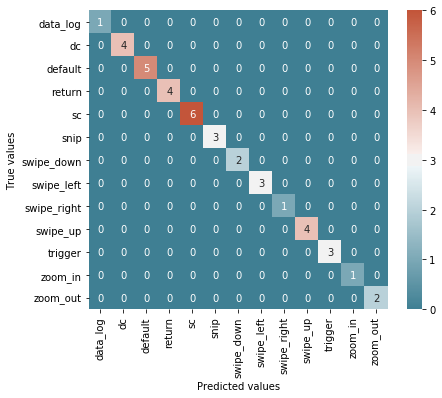

In [14]:
cf_matrix(clf, X_test, y_test)

##### Crossval Score - Applied to complete dataset

In [15]:
X = preprocess_raw_data(X_raw, frame_size)
cross_val(clf, X, y)

Crossval score Accuracy:                 0.98 (+/- 0.06)
